# Habitat Compression Index

In [2]:
import numpy as np
import xarray as xr
from dask.distributed import Client


In [5]:
# opendap
# ds_mask = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/cookbook/data/nmme/hci_total_mask.nc')
# local
ds_mask = xr.open_dataset('/Datasets.private/marinehw/nmme_marine_index_mask/hci_total_mask.nc')

In [7]:
link = "http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst_regridded/dods"
ds_nmme = xr.open_dataset(link, chunks={'M':1,'L':1,'S':1},decode_times=False)

In [8]:
ds_nmme = ds_nmme.isel(S=slice(-2,None),M=slice(0,5)).load()

In [9]:
ds_nmme

<xarray.Dataset> Size: 31MB
Dimensions:        (L: 12, S: 2, M: 5, X: 360, Y: 181)
Coordinates:
  * L              (L) float32 48B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * S              (S) float32 8B 772.0 773.0
  * M              (M) float32 20B 1.0 2.0 3.0 4.0 5.0
  * X              (X) float32 1kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * Y              (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Data variables:
    sst_regridded  (S, L, M, Y, X) float32 31MB nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  IRIDL

In [10]:
import cftime
# all available initial time in the link
ds_nmme['S'] = cftime.num2date(
    ds_nmme.S.values,
    ds_nmme.S.units,
    calendar='360_day'
)

In [11]:
ds_nmme['S'] 

<xarray.DataArray 'S' (S: 2)> Size: 16B
array([cftime.Datetime360Day(2024, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2024, 6, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * S        (S) object 16B 2024-05-01 00:00:00 2024-06-01 00:00:00

In [12]:
# opendap
# ds_threshold = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/cookbook/data/nmme/GFDL-SPEAR-regridded_climo_threshold_hci.nc')
# local 
ds_threshold = xr.open_dataset('/Datasets.private/marinehw/nmme_sst_stat/GFDL-SPEAR-regridded_climo_threshold_hci.nc')

In [13]:
ds_threshold['month'] = ds_threshold['month'].data.astype('int')

In [14]:
ds_threshold

<xarray.Dataset> Size: 720B
Dimensions:        (L: 12, month: 12)
Coordinates:
  * L              (L) float32 48B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hci_threshold  (month, L) float32 576B ...

In [25]:
# called compute because da_sst is used twice in the following operation
da_sst = (ds_mask['HCI_150km']*ds_nmme['sst_regridded']).compute()


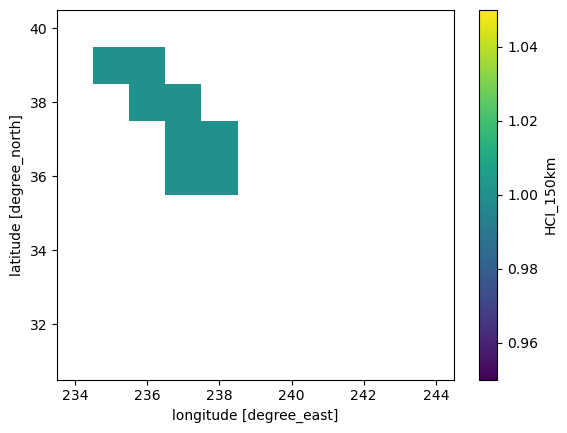

In [24]:
ds_mask['HCI_150km'].plot()

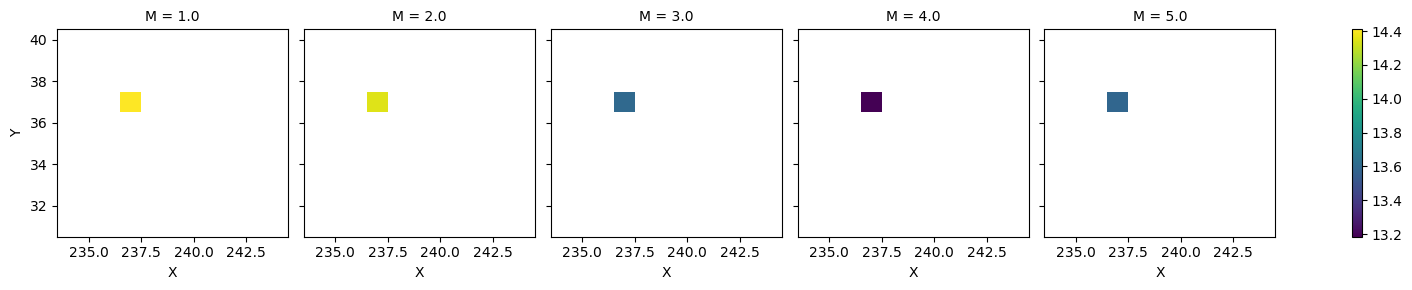

In [26]:
da_sst.isel(L=0,S=-2).plot(col='M')

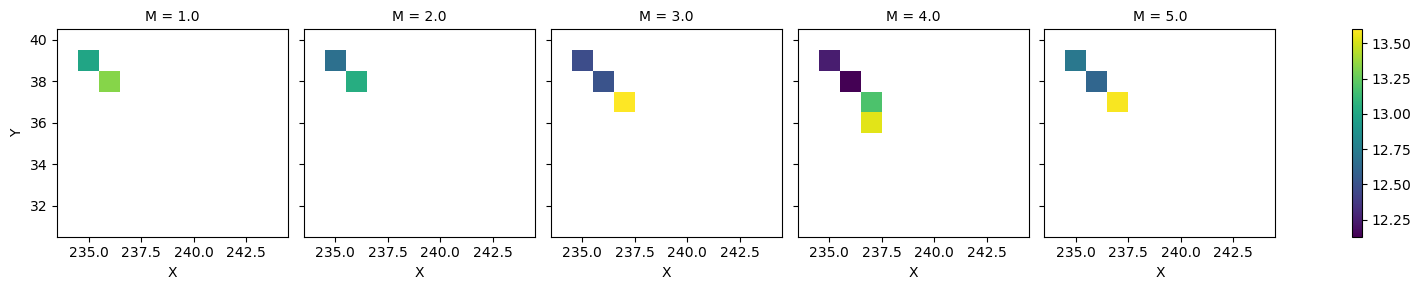

In [17]:
da_hci = da_sst.where(da_sst.groupby('S.month')<=ds_threshold['hci_threshold'])
da_hci.isel(L=0,S=-2).plot(col='M')

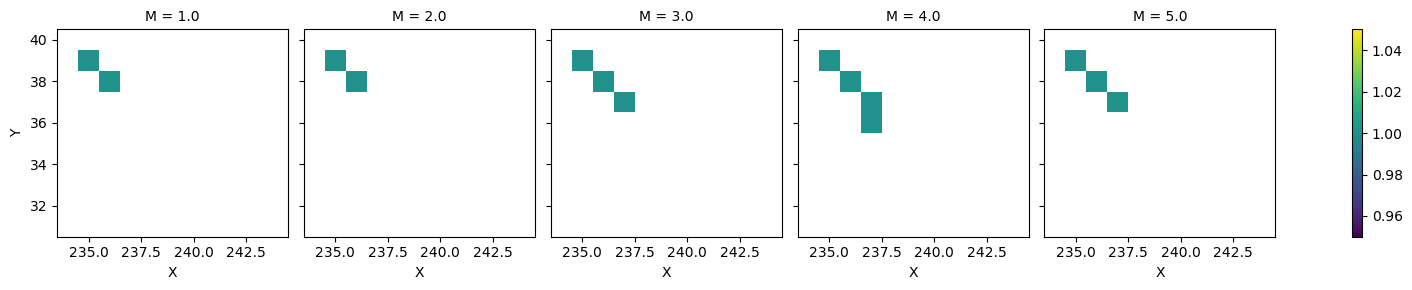

In [18]:
da_hci = da_hci.where(da_hci.isnull(),other=1)
da_hci.isel(L=0,S=-2).plot(col='M')

In [19]:
da_hci = da_hci.sum(dim=['X','Y'],skipna=True)

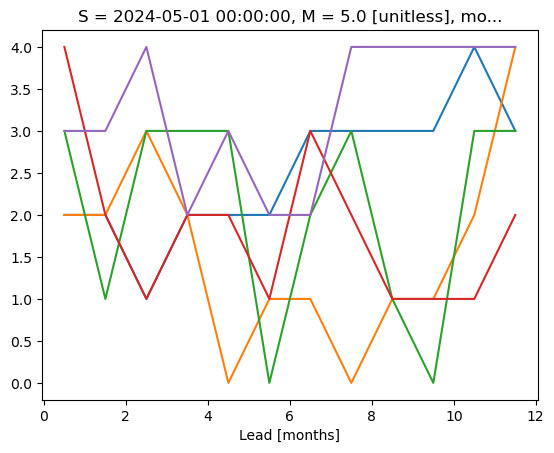

In [20]:
for m in da_hci.M:
    da_hci.isel(S=-2).sel(M=m).plot()

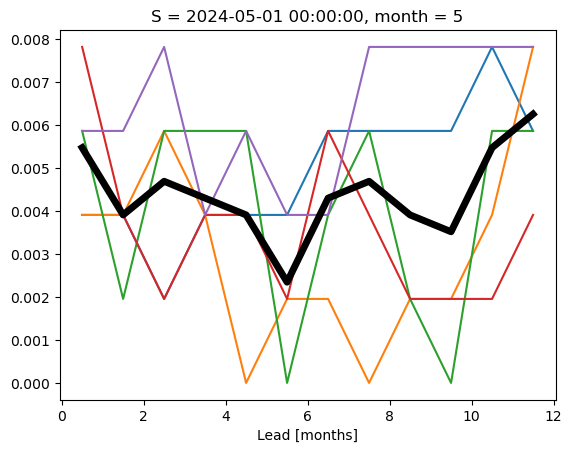

In [23]:
da_total_grids = ds_mask['HCI_150km'].sum(dim=['X','Y'],skipna=True)
da_hci = da_hci/da_total_grids
for m in da_hci.M:
    da_hci.isel(S=-2).sel(M=m).plot()

da_hci.mean(dim='M').isel(S=-2).plot(color='k',linewidth=5)